# PCOS Hematology–Androgen Study — Data Preprocessing  
**Notebook:** 02_preprocessing.ipynb  
**Version:** v1.0
**Author:** Natalia Piórkowska  
**Date:** 2026-02-15  

## Purpose  
This notebook documents all preprocessing steps for the cross-sectional PCOS cohort, ensuring full reproducibility and compliance with STROBE/RB&E standards.  
The pipeline includes:  
1. Import and audit of raw data.  
2. Controlled mapping of raw laboratory column names to analysis-ready variables.  
3. Numeric parsing (decimal separators and qualifiers) with conversion logs.  
4. Missing-data assessment and a priori exclusion of variables with >30% missingness.  
5. Clinical plausibility checks and outlier logging without participant deletion.  
6. Computation of derived indices (FAI, LH/FSH, NLR, PLR, MPR).  
7. Creation of two analysis sets:  
   - **df_main** (available-case; main analyses),  
   - **df_cc** (complete-case; selection-bias & sensitivity only).  
8. Export of cleaned datasets and supplementary logs.

> **Key principle:** No global `dropna()` is applied to the main dataset. Available-case inference is preserved.


## Analytical Strategy

Two analytical datasets are generated:

1. Main available-case dataset  
   → Used for primary regression analyses.  
   → Includes all participants with available exposure and outcome data required for each specific model.

2. Complete-case dataset  
   → Used for sensitivity analyses.  
   → Includes only participants with complete data across all key exposure and outcome variables.

The available-case approach was selected as the primary strategy to maximize statistical power while minimizing unnecessary exclusion of participants.



## Eligibility, Exclusions, and Data Availability

This notebook implements all preprocessing decisions used to define the final analytical datasets.

### Key data availability
- BMI was not available in the source dataset and therefore could not be used for exclusion or as an adjustment covariate.

### Exclusions and preprocessing rules (implemented below)
1. Variable-level exclusion due to missingness threshold (>30%) is applied and logged (see S1 outputs).
2. Clinical plausibility checks are performed using predefined ranges and logged (Sy outputs).
3. Outliers are flagged using the IQR rule; no automatic removal is applied unless explicitly justified (Sy outputs).
4. A complete-case dataset is generated for sensitivity analysis and selection-bias assessment (S2 outputs).

All steps are reproducible and documented via exported logs.



### Units and reference ranges

Before final submission, **verify units in the raw export** and, if needed, adjust the plausibility ranges in `bio_limits`.  


If any hormone is recorded in different units across patients, harmonize to a single unit here and document conversion.


## Note on distributional assumptions (analysis stage)

No transformations are applied in preprocessing.  
In `03_analysis.ipynb`, distributions will be inspected (histograms/QQ-plots).  
Skewed variables will be analyzed using **Spearman** correlations and/or **log‑transformed** for regression models.  
Per‑analysis sample sizes (available‑case) will be reported.


## Imports

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.stats as stats
import re

pd.set_option("display.max_columns", 250)
pd.set_option("display.float_format", lambda x: f"{x:.4f}")


OUT_DIR = Path("outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("Saving outputs to:", OUT_DIR.resolve())




Saving outputs to: /content/outputs


## Load raw data
Provide the raw `.xlsx` obtained from the clinical database. No edits should be made outside this notebook.


In [ ]:
DATA_PATH = Path("patients_results.xlsx")
df_raw = pd.read_excel(DATA_PATH)

print("Raw shape:", df_raw.shape)
df_raw.head()


Raw shape: (1300, 202)


,Nr KG,Rok KG,Przyjęcie na oddział zlecający,Wypis z oddziału zlecającego,Wiek,17 - OH progesteron (L79) (17-OHPG),17 OH progesteron (L79),ALAT (ALT),AMH (hormon anty-Mullerowski) (AMH_CP),AMH-anty Mullerian Hormon (AMH),APTT Czas kaolinowo-kefalinowy (APTTCZ),ASO - ilościowo (ASOIL),ASPAT (AST),Androstendion (ANDRO),Androstendion (I31),Androstendion (I31) (ANDRO),Anty - HCV (L_ANTHCV),Anty-TG (O18),Anty-TG (p/c przeciw tyreoglobulinie) (ATG),Anty-TPO (ATA_TPO),Białko C-reaktywne (CRP),Bilirubina całkowita (TBIL),CEA (CEA),Ca125 (CA125),Ca19.9 (CA199),Cholesterol całkowity (TCHOL),D-dimery (DDIMER),DHEAS (DHEA),Dobowy rytm tolerancji glukozy (L_G1030),Dobowy rytm tolerancji glukozy (L_G1200),Dobowy rytm tolerancji glukozy (L_G1500),Dobowy rytm tolerancji glukozy (L_G1800),Dobowy rytm tolerancji glukozy (L_G2100),Dobowy rytm tolerancji glukozy (L_G2400),Dobowy rytm tolerancji glukozy (L_G330),Dobowy rytm tolerancji glukozy (L_G700),Dokument (NAZWA),Estradiol (ESTRA),Estradiol (L_ESTRA),FSH (FSH),FSH 0' 30' 60' (L_FSH0),FSH 0' 30' 60' (L_FSH30),FSH 0' 30' 60' (L_FSH60),FT3 (FT3),FT4 (FT4),Ferrytyna (FERR),Ferrytyna (L05),Fibrynogen (L_FIB),Fosforany nieorganiczne (FOSFOR),GH (hormon wzrostu) (L_GH),Gamma Glutamylotranspeptydaza (GGTP),Glukoza (L_GLU),"Grypa A, B, RSV, SARS-CoV2 antygen - badanie jakościowe (COV2_G)","Grypa A, B, RSV, SARS-CoV2 antygen - badanie jakościowe (GRYA)","Grypa A, B, RSV, SARS-CoV2 antygen - badanie jakościowe (GRYB)","Grypa A, B, RSV, SARS-CoV2 antygen - badanie jakościowe (GRYRSV)",HBSAG (L_HBSAG),HBsAg (L_HBSAG),HDL cholesterol (HDL),HbsAg (HBSAG),Hemoglobina glikowana (HBA1C_1),Hemoglobina glikowana (HBA1C_2),Hemoglobina glikowana (L53.IFC),Hemoglobina glikowana (L55),IGF-1 (insulinopodobny czynnik wzrostu 1) (IGF1_L),Insulina (INSUL),Insulina po 75g glukozy (3pkt.) (INSUL_0),Insulina po 75g glukozy (3pkt.) (INSUL_1),Insulina po 75g glukozy (3pkt.) (INSUL_2),"Insulina po obciążeniu 75 g glukozy 0,1,2,3 (L97 0m)","Insulina po obciążeniu 75 g glukozy 0,1,2,3 (L97 120m)","Insulina po obciążeniu 75 g glukozy 0,1,2,3 (L97 30m)","Insulina po obciążeniu 75 g glukozy 0,1,2,3 (L97 60m)","Insulina po obciążeniu 75 g glukozy 0,1,2,3 (L97_0)","Insulina po obciążeniu 75 g glukozy 0,1,2,3 (L97_1)","Insulina po obciążeniu 75 g glukozy 0,1,2,3 (L97_2)","Jonogram (Sód, potas, chlorki) (L_CI)","Jonogram (Sód, potas, chlorki) (L_K)","Jonogram (Sód, potas, chlorki) (L_NA)",Kortyzol godz. 08:00 (KOR),Kortyzol godz. 23:00 (KOR23),Kortyzol na czczo (KORCZ),Kortyzol po Dexamethasonie (KORD),Kortyzol po Dexamethasonie [1mg] (KORD),Kortyzol po Dexamethasonie [2mg] (KOR2DXM),Kortyzol po Dexamethasonie [4mg] (KOR4DXM),Kreatynina (KREAT),Krzywa cukrowa - 2 punktowa (GLU120),Krzywa cukrowa - 2 punktowa (L_GLU_0),LDL cholesterol (LDL),LH (LH),LH 0' 30' 60' (LH0),LH 0' 30' 60' (L_LH30),LH 0' 30' 60' (L_LH60),MDRD GFR (MDRD),Mocz - badanie ogólne (MBARWA),Mocz - badanie ogólne (MBIALK),Mocz - badanie ogólne (MBILI),Mocz - badanie ogólne (MCIEZA),Mocz - badanie ogólne (MCUKIE),Mocz - badanie ogólne (MERY),Mocz - badanie ogólne (MKETON),Mocz - badanie ogólne (MLEU),Mocz - badanie ogólne (MNIT),Mocz - badanie ogólne (MOSAD),Mocz - badanie ogólne (MPH),Mocz - badanie ogólne (MPRZEJ),Mocz - badanie ogólne (MUROBI),Morfologia CBC (HCT),Morfologia CBC (HGB),Morfologia CBC (MCH),Morfologia CBC (MCHC),Morfologia CBC (MCV),Morfologia CBC (MPV),Morfologia CBC (NRBC_B),Morfologia CBC (NRBC_P),Morfologia CBC (PCT),Morfologia CBC (PDW),Morfologia CBC (PLCR),Morfologia CBC (PLT),Morfologia CBC (RBC),Morfologia CBC (RDW),Morfologia CBC (RDWSD),Morfologia CBC (WBC),"Morfologia krwi, z pełnym różnicowaniem granulocytów (leukocytów) z rozmazem - 5 Diff (BASO)","Morfologia krwi, z pełnym różnicowaniem granulocytów (leukocytów) z rozmazem - 5 Diff (BASOB)","Morfologia krwi, z pełnym różnicowaniem granulocytów (leukocytów) z rozmazem - 5 Diff (EOS#)","Morfologia krwi, z pełnym różnicowaniem granulocytów (leukocytów) z rozmazem - 5 Diff (EOS)","Morfologi

### Raw data description
The raw dataset includes women diagnosed with PCOS according to Rotterdam criteria (clinical details described in the main Methods section).  
All preprocessing, exclusions, and derived variables are performed below.


## Map raw column names to short analysis variables

**Rationale.** The raw Excel file uses long laboratory labels.  
To avoid KeyErrors and preserve reproducibility, we first apply a deterministic mapping from exact raw labels to short names used in analyses.  
Only then do we proceed to parsing and cleaning.


In [ ]:
raw_to_short = {

    "Testosteron (L_TESTOS)": "Testosteron",
    "DHEAS (DHEA)": "DHEAS",
    "Androstendion (ANDRO)": "Androstendion",
    "SHBG (L_SHGB)": "SHBG",
    "FSH (FSH)": "FSH",
    "LH  (LH)": "LH",
    "AMH (hormon anty-Mullerowski) (AMH_CP)": "AMH",
    "PRL godz. 10:00 (PRL10)": "PRL",
}


cbc5_prefix = "Morfologia krwi, z pełnym różnicowaniem granulocytów (leukocytów) z rozmazem - 5 Diff"

cbc5_map = {
    f"{cbc5_prefix} (PLT)": "PLT",
    f"{cbc5_prefix} (PLCR)": "PLCR",
    f"{cbc5_prefix} (PCT)": "PCT",
    f"{cbc5_prefix} (MPV)": "MPV",
    f"{cbc5_prefix} (PDW)": "PDW",
    f"{cbc5_prefix} (RDW)": "RDW",
    f"{cbc5_prefix} (RDWSD)": "RDWSD",
    f"{cbc5_prefix} (LIM#)": "LIM#",
    f"{cbc5_prefix} (MON)": "MON",
    f"{cbc5_prefix} (MON#)": "MON#",
    f"{cbc5_prefix} (NEUT)": "NEUT",
    f"{cbc5_prefix} (NEUT#)": "NEUT#",
    f"{cbc5_prefix} (EOS)": "EOS",
    f"{cbc5_prefix} (EOS#)": "EOS#",
    f"{cbc5_prefix} (BASO)": "BASO",
    f"{cbc5_prefix} (BASOB)": "BASOB",
    f"{cbc5_prefix} (IG_P)": "IG_P",
    f"{cbc5_prefix} (IG_B)": "IG_B",
    f"{cbc5_prefix} (NRBC_P)": "NRBC_P",
    f"{cbc5_prefix} (NRBC_B)": "NRBC_B",
}
raw_to_short.update(cbc5_map)


raw_to_short = {k: v for k, v in raw_to_short.items() if k in df_raw.columns}


df = df_raw.rename(columns=raw_to_short).copy()

print("Shape after mapping:", df.shape)
print("Mapped variables:", sorted(set(raw_to_short.values())))


Shape after mapping: (1300, 202)
Mapped variables: ['AMH', 'Androstendion', 'BASO', 'BASOB', 'DHEAS', 'EOS', 'EOS#', 'FSH', 'IG_B', 'IG_P', 'LH', 'LIM#', 'MON', 'MON#', 'MPV', 'NEUT', 'NEUT#', 'NRBC_B', 'NRBC_P', 'PCT', 'PDW', 'PLCR', 'PLT', 'PRL', 'RDW', 'RDWSD', 'SHBG', 'Testosteron']


## Define variable groups

The groups used in the analysis are explicitly defined to ensure transparency and ease of auditing.


In [ ]:
androgen_cols = ["Testosteron", "DHEAS", "Androstendion", "SHBG"]
gonad_cols = ["FSH", "LH", "AMH", "PRL"]

cbc_platelet_cols = ["PLT","PLCR","PCT","MPV","PDW"]
cbc_rbc_cols = ["RDW","RDWSD"]
cbc_wbc_cols = ["LIM#","MON","MON#","NEUT","NEUT#","EOS","EOS#",
                "BASO","BASOB","IG_P","IG_B","NRBC_P","NRBC_B"]


covariate_cols = [c for c in ["Wiek","BMI","Palenie","HOMA_IR","Glikemia"] if c in df.columns]

all_numeric_cols = [c for c in (androgen_cols + gonad_cols + cbc_platelet_cols +
                                cbc_rbc_cols + cbc_wbc_cols + covariate_cols)
                    if c in df.columns]

all_numeric_cols


['Testosteron',
 'DHEAS',
 'Androstendion',
 'SHBG',
 'FSH',
 'LH',
 'AMH',
 'PRL',
 'PLT',
 'PLCR',
 'PCT',
 'MPV',
 'PDW',
 'RDW',
 'RDWSD',
 'LIM#',
 'MON',
 'MON#',
 'NEUT',
 'NEUT#',
 'EOS',
 'EOS#',
 'BASO',
 'BASOB',
 'IG_P',
 'IG_B',
 'NRBC_P',
 'NRBC_B',
 'Wiek']

## Controlled numeric parsing

**Policy.**  
- Decimal commas are converted to dots.  
- Qualifiers like `<`, `>` and whitespace are removed.  
- Non‑numeric cells are *coerced to missing (NaN)* rather than excluding participants.  
A conversion log is exported for Supplementary Materials.


In [ ]:
def parse_numeric(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.strip()
    s = s.str.replace(",", ".", regex=False)
    s = s.str.replace(r"[<> ]", "", regex=True)
    s = s.replace({"": np.nan, "nan": np.nan, "None": np.nan})
    return pd.to_numeric(s, errors="coerce")

df_parsed = df.copy()
for col in all_numeric_cols:
    df_parsed[col] = parse_numeric(df_parsed[col])

df_parsed[all_numeric_cols].head()


,Testosteron,DHEAS,Androstendion,SHBG,FSH,LH,AMH,PRL,PLT,PLCR,PCT,MPV,PDW,RDW,RDWSD,LIM#,MON,MON#,NEUT,NEUT#,EOS,EOS#,BASO,BASOB,IG_P,IG_B,NRBC_P,NRBC_B,Wiek
0,0.8410,379.0000,2.9100,63.4000,10.1000,NaN,7.5000,11.3000,349.0000,25.9000,0.3500,10.2000,11.7000,12.4000,40.7000,2.2900,5.8000,0.5700,68.8000,6.7200,1.3000,0.1300,0.4000,0.0400,0.3000,0.0300,0.0000,0.0000,25
1,0.2380,340.0000,0.7200,21.1000,5.4500,3.0800,2.8200,12.4000,221.0000,27.2000,0.2300,10.2000,11.0000,12.7000,40.0000,3.3300,6.2000,0.4000,41.4000,2.6700,0.0000,0.0000,0.6000,0.0400,0.2000,0.0100,0.0000,0.0000,25
2,0.4950,462.0000,1.7200,45.7000,7.0300,5.6500,7.6200,10.9000,305.0000,24.1000,0.3000,9.8000,11.2000,12.7000,39.7000,2.5000,9.6000,0.5200,42.5000,2.2900,0.7000,0.0400,0.7000,0.0400,0.2000,0.0100,0.0000,0.0000,25
3,0.5310,310.0000,1.9300,36.9000,5.8400,11.1000,10.5000,7.5100,224.0000,38.5000,0.2600,11.5000,15.5000,13.1000,40.9000,3.0200,8.0000,0.5100,40.6000,2.5800,3.3000,0.2100,0.3000,0.0200,0.3000,0.0200,0.0000,0.0000,25
4,0.1690,166.0000,0.9700,34.5000,6.5700,9.4600,2.2600,8.9000,322.0000,25.2000,0.3300,10.1000,11.2000,12.7000,43.2000,2.8300,5.9000,0.4800,56.3000,4.5600,2.5000,0.2000,0.2000,0.0200,0.2000,0.0200,0.0000,0.0000,25


### Numeric parsing log


In [ ]:
conversion_report = []
for col in all_numeric_cols:
    n_before = df[col].notna().sum()
    n_after = df_parsed[col].notna().sum()
    conversion_report.append({
        "variable": col,
        "nonmissing_raw": int(n_before),
        "nonmissing_parsed": int(n_after),
        "coerced_to_nan": int(n_before - n_after)
    })

conversion_report_df = pd.DataFrame(conversion_report).sort_values("coerced_to_nan", ascending=False)
conversion_report_df.head(20)


,variable,nonmissing_raw,nonmissing_parsed,coerced_to_nan
1,DHEAS,1185,1164,21
0,Testosteron,1181,1162,19
4,FSH,1182,1176,6
5,LH,1182,1176,6
7,PRL,1179,1175,4
6,AMH,988,986,2
2,Androstendion,691,689,2
3,SHBG,1180,1179,1
8,PLT,912,911,1
9,PLCR,912,911,1


## Missing-data assessment and variable exclusion (>30%)

**Policy.** Variables with >30% missingness are excluded a priori to avoid unstable estimates.  
Remaining analyses use **available-case** inference. Per-analysis N will be reported.


### Missingness Threshold Rationale

Variables with more than 30% missing values were excluded from downstream analyses.  
This threshold was selected to balance data retention with the risk of instability and bias associated with sparse variables.

The list of removed variables is provided in Supplementary Table S1.


In [ ]:
missing_pct = df_parsed[all_numeric_cols].isna().mean() * 100
missing_table = missing_pct.sort_values(ascending=False).to_frame("missing_%")
missing_table.head(30)


,missing_%
Androstendion,47.0000
PLCR,29.9231
PCT,29.9231
MPV,29.9231
PLT,29.9231
EOS,29.9231
NEUT#,29.9231
NEUT,29.9231
MON#,29.9231
MON,29.9231


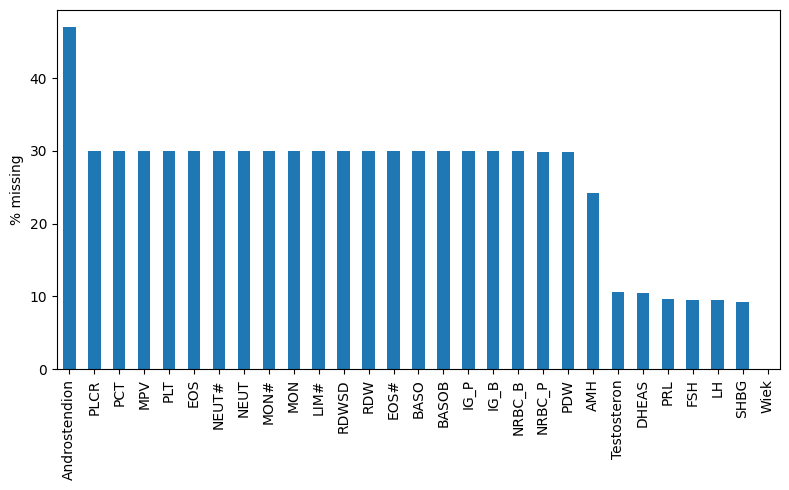

In [ ]:
plt.figure(figsize=(8,5))
missing_pct.sort_values(ascending=False).plot(kind="bar")
plt.ylabel("% missing")
plt.tight_layout()
plt.show()


In [ ]:
THRESH = 30
protected_cols = [c for c in ["LIM#","NEUT#","PLT","MPV"] if c in missing_pct.index]

cols_over_thresh = missing_pct[(missing_pct > THRESH) & (~missing_pct.index.isin(protected_cols))].index.tolist()
df_reduced = df_parsed.drop(columns=cols_over_thresh)

print("Protected from missingness-cut:", protected_cols)
print("Removed columns (>30% missing, not protected):", cols_over_thresh)
print("Shape after removing columns:", df_reduced.shape)


missing_table = missing_table.reset_index().rename(columns={"index": "variable"})
missing_table = missing_table[["variable", "missing_%"]].sort_values("missing_%", ascending=False)

removed_table = missing_table[missing_table["variable"].isin(cols_over_thresh)].copy()


missing_table.to_excel(OUT_DIR / "S1_missingness_all_vars.xlsx", index=False)
removed_table.to_excel(OUT_DIR / "S1_removed_columns_missingness.xlsx", index=False)

print("Wrote:", OUT_DIR / "S1_missingness_all_vars.xlsx")
print("Wrote:", OUT_DIR / "S1_removed_columns_missingness.xlsx")


Protected from missingness-cut: ['LIM#', 'NEUT#', 'PLT', 'MPV']
Removed columns (>30% missing, not protected): ['Androstendion']
Shape after removing columns: (1300, 201)
Wrote: outputs/S1_missingness_all_vars.xlsx
Wrote: outputs/S1_removed_columns_missingness.xlsx


## Clinical plausibility checks

**Policy.** Values outside biologically plausible ranges are set to missing (NaN).  
No participant is removed at this step. Corrections are logged.
> **Note:** Adjust ranges below to match your laboratory units if needed.


### Units and reference ranges (to confirm before submission)

Before final submission, **verify units in the raw export** and, if needed, adjust the plausibility ranges in `bio_limits`.  



Biological plausibility ranges were defined based on established clinical laboratory reference ranges and published endocrinological standards.


In [ ]:
bio_limits = {
    "Testosteron": (0, 10),
    "DHEAS": (0, 1000),
    "Androstendion": (0, 20),
    "SHBG": (1, 300),
    "FSH": (0.1, 50),
    "LH": (0.1, 80),
    "AMH": (0.0, 30),
    "PRL": (0.0, 200),
    "PLT": (50, 1000),
    "MPV": (5, 20),
    "RDW": (8, 25),
}

df_bio = df_reduced.copy()
impossible_log = []

for col, (low, high) in bio_limits.items():
    if col in df_bio.columns:
        mask = (df_bio[col] < low) | (df_bio[col] > high)
        n_imp = int(mask.sum())
        if n_imp > 0:
            impossible_log.append({
                "variable": col,
                "n_outside_range": n_imp,
                "low": low,
                "high": high
            })
            df_bio.loc[mask, col] = np.nan

impossible_log_df = pd.DataFrame(impossible_log)
impossible_log_df["range_source"] = "Predefined clinical plausibility rules (Methods/Supplement)"
impossible_log_df


,variable,n_outside_range,low,high,range_source
0,DHEAS,2,0.0000,1000,Predefined clinical plausibility rules (Method...
1,SHBG,1,1.0000,300,Predefined clinical plausibility rules (Method...
2,FSH,4,0.1000,50,Predefined clinical plausibility rules (Method...
3,AMH,2,0.0000,30,Predefined clinical plausibility rules (Method...


In [ ]:
impossible_log_df.to_excel(OUT_DIR / "Sy_biological_plausibility_log.xlsx", index=False)
print("Wrote:", OUT_DIR / "Sy_biological_plausibility_log.xlsx")


Wrote: outputs/Sy_biological_plausibility_log.xlsx


## Outlier logging (IQR rule)

Outliers are **not removed** from df_main to avoid data-dependent bias.  
Their frequency is reported; sensitivity analyses may winsorize if required.


### Outlier Handling Policy

Outliers were identified using the 1.5 × IQR rule and logged.  
No automatic removal or winsorization was applied at this stage.

Outliers were retained in the primary dataset unless:
- values were biologically implausible, or
- clear measurement/data-entry errors were identified.

This conservative approach was chosen to avoid artificial distortion of clinical variability.


In [ ]:
def iqr_outliers(s: pd.Series) -> pd.Series:
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    return (s < low) | (s > high)

outlier_counts = []
for col in all_numeric_cols:
    if col in df_bio.columns:
        s = df_bio[col].dropna()
        if len(s) > 5:
            n_out = int(iqr_outliers(s).sum())
            outlier_counts.append({
                "variable": col,
                "iqr_outliers_n": n_out,
                "n_nonmissing": int(len(s))
            })

outlier_table = pd.DataFrame(outlier_counts).sort_values("iqr_outliers_n", ascending=False)
outlier_table["rule"] = "1.5xIQR"
outlier_table["action"] = "flag_only"
outlier_table.head(20)


,variable,iqr_outliers_n,n_nonmissing,rule,action
23,IG_P,122,911,1.5xIQR,flag_only
4,LH,74,1176,1.5xIQR,flag_only
20,EOS#,52,911,1.5xIQR,flag_only
24,IG_B,52,911,1.5xIQR,flag_only
6,PRL,48,1175,1.5xIQR,flag_only
25,NRBC_P,46,912,1.5xIQR,flag_only
26,NRBC_B,46,911,1.5xIQR,flag_only
19,EOS,41,911,1.5xIQR,flag_only
12,RDW,34,911,1.5xIQR,flag_only
0,Testosteron,32,1162,1.5xIQR,flag_only


In [ ]:
outlier_table.to_excel(OUT_DIR / "Sy_outliers_IQR_log.xlsx", index=False)
print("Wrote:", OUT_DIR / "Sy_outliers_IQR_log.xlsx")


Wrote: outputs/Sy_outliers_IQR_log.xlsx


## Derived indices

Derived (exploratory) indices are computed as:
- LH/FSH ratio  
- FAI = (Testosterone / SHBG) × 100  
- NLR = NEUT# / LIM#  
- PLR = PLT / LIM#  
- MPR = MPV / PLT


In [ ]:
def safe_div(a: pd.Series, b: pd.Series) -> pd.Series:
    a = pd.to_numeric(a, errors="coerce")
    b = pd.to_numeric(b, errors="coerce")
    b = b.replace({0: np.nan})
    return a / b

df_main = df_bio.copy()

# LH/FSH
if "LH" in df_main.columns and "FSH" in df_main.columns:
    df_main["LH_FSH"] = safe_div(df_main["LH"], df_main["FSH"])

# FAI
if "Testosteron" in df_main.columns and "SHBG" in df_main.columns:
    df_main["FAI"] = safe_div(df_main["Testosteron"], df_main["SHBG"]) * 100

# NLR
if "NEUT#" in df_main.columns and "LIM#" in df_main.columns:
    df_main["NLR"] = safe_div(df_main["NEUT#"], df_main["LIM#"])

# PLR
if "PLT" in df_main.columns and "LIM#" in df_main.columns:
    df_main["PLR"] = safe_div(df_main["PLT"], df_main["LIM#"])

# MPR
if "MPV" in df_main.columns and "PLT" in df_main.columns:
    df_main["MPR"] = safe_div(df_main["MPV"], df_main["PLT"])

present_derived = [c for c in ["LH_FSH","FAI","NLR","PLR","MPR"] if c in df_main.columns]
df_main[present_derived].head()


,LH_FSH,FAI,NLR,PLR,MPR
0,NaN,1.3265,2.9345,152.4017,0.0292
1,0.5651,1.1280,0.8018,66.3664,0.0462
2,0.8037,1.0832,0.9160,122.0000,0.0321
3,1.9007,1.4390,0.8543,74.1722,0.0513
4,1.4399,0.4899,1.6113,113.7809,0.0314


## Complete-case dataset for sensitivity / selection bias

A complete-case dataset is created only for sensitivity analyses and selection-bias assessment.  
It is **not** used for primary available-case analyses.


### Selection Bias Assessment

To evaluate potential selection bias introduced by complete-case restriction, demographic and key laboratory variables were compared between included and excluded participants.

Results are provided in Supplementary Table S2.


In [ ]:
cc_required = ["Testosteron","DHEAS","SHBG","FAI","MPV","RDW","PLT"]
cc_required = [c for c in cc_required if c in df_main.columns]

df_cc = df_main.dropna(subset=cc_required).copy()

print("df_main shape (available-case):", df_main.shape)
print("df_cc shape (complete-case):", df_cc.shape)


df_main shape (available-case): (1300, 206)
df_cc shape (complete-case): (905, 206)


### Selection bias: included vs excluded


In [ ]:
df_included = df_cc
df_excluded = df_main.loc[~df_main.index.isin(df_cc.index)]

baseline_cols = [c for c in (["Wiek","BMI"] + androgen_cols + gonad_cols) if c in df_main.columns]

bias_results = []
for col in baseline_cols:
    x = df_included[col].dropna()
    y = df_excluded[col].dropna()
    if len(x) > 2 and len(y) > 2:
        stat, p = stats.mannwhitneyu(x, y, alternative="two-sided")
        bias_results.append({
            "variable": col,
            "median_included": float(x.median()),
            "median_excluded": float(y.median()),
            "p_value": float(p),
            "n_included": int(len(x)),
            "n_excluded": int(len(y))
        })

bias_table = pd.DataFrame(bias_results).sort_values("p_value")
bias_table


,variable,median_included,median_excluded,p_value,n_included,n_excluded
0,Wiek,22.0000,19.0000,0.0000,905,395
7,PRL,9.7900,11.7700,0.0000,901,274
4,FSH,5.9050,5.3650,0.0000,898,274
1,Testosteron,0.3750,0.3590,0.0358,905,257
3,SHBG,47.0000,50.2900,0.1389,905,273
6,AMH,5.6300,6.6700,0.1687,900,84
5,LH,7.2300,6.7400,0.2807,901,275
2,DHEAS,320.0000,314.9000,0.7145,905,257


In [ ]:
bias_table.to_excel(OUT_DIR / "S2_selection_bias_included_vs_excluded.xlsx", index=False)
print("Wrote:", OUT_DIR / "S2_selection_bias_included_vs_excluded.xlsx")


Wrote: outputs/S2_selection_bias_included_vs_excluded.xlsx


## Final sanity checks and export


In [ ]:
df_main.describe().T.head(40)


,count,mean,min,25%,50%,75%,max,std
Nr KG,1300.0000,21247.0392,56.0000,9906.5000,20912.0000,31613.5000,49493.0000,12972.3251
Rok KG,1300.0000,2022.1977,2018.0000,2021.0000,2023.0000,2024.0000,2025.0000,1.9107
Przyjęcie na oddział zlecający,1300,2022-09-02 08:10:40.200000,2018-01-29 10:38:00,2021-03-18 04:05:00,2023-01-18 10:53:00,2024-04-16 08:45:15,2025-05-06 10:55:00,NaN
Wypis z oddziału zlecającego,1300,2022-09-06 01:55:55.430769152,2018-02-01 10:38:00,2021-03-23 02:37:15,2023-01-21 22:19:00,2024-04-19 09:52:00,2025-05-09 09:29:00,NaN
Wiek,1300.0000,20.9231,16.0000,19.0000,21.0000,22.0000,25.0000,1.9490
AMH,984.0000,6.3945,0.0100,3.7800,5.7150,8.4000,27.8000,3.6429
ASO - ilościowo (ASOIL),1.0000,9.0000,9.0000,9.0000,9.0000,9.0000,9.0000,NaN
DHEAS,1162.0000,338.0128,30.9000,245.0000,319.5000,415.0000,935.0000,133.6137
Dobowy rytm tolerancji glukozy (L_G1030),7.0000,113.4286,81.0000,101.0000,122.0000,124.5000,140.0000,21.3218
Dobowy rytm tolerancji glukozy (L_G1200),7.0000,102.1429,76.0000,95.5000,106.0000,108.0000,126.0000,16.1805


In [ ]:
df_main.to_excel(OUT_DIR / "cleaned_PCOS_df_main_available_case.xlsx", index=False)
df_cc.to_excel(OUT_DIR / "cleaned_PCOS_df_cc_complete_case.xlsx", index=False)

print("Exported:", OUT_DIR / "cleaned_PCOS_df_main_available_case.xlsx")
print("Exported:", OUT_DIR / "cleaned_PCOS_df_cc_complete_case.xlsx")


Exported: outputs/cleaned_PCOS_df_main_available_case.xlsx
Exported: outputs/cleaned_PCOS_df_cc_complete_case.xlsx


# Preprocessing Conclusions

1. Variables exceeding 30% missingness were removed.
2. Biological plausibility checks were applied and logged.
3. Outliers were identified but conservatively retained.
4. Two analytical datasets were generated (available-case and complete-case).
5. Selection bias associated with complete-case restriction was assessed.

These datasets are used for inferential modeling in Notebook 03.
